In [277]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [278]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [279]:
len(words)

32033

In [280]:
ALPHABET_SIZE = 27

In [281]:
N = torch.ones((ALPHABET_SIZE, ALPHABET_SIZE, ALPHABET_SIZE), dtype=torch.int32)

In [282]:
all_chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(all_chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}

In [283]:
for word in words:
    chars = '.' + '.' + word + '.'
    for a, b, c in zip(chars, chars[1:], chars[2:]):
        ix1 = stoi[a]
        ix2 = stoi[b]
        ix3 = stoi[c]
        N[ix1, ix2, ix3] += 1

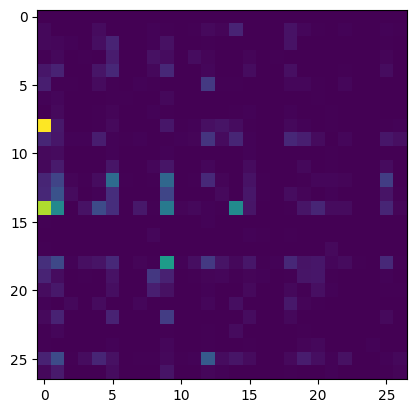

In [284]:
plt.imshow(N[1])

In [285]:
probs = N.float()
probs /= probs.sum(dim=2, keepdim=True)
probs.shape

torch.Size([27, 27, 27])

In [286]:
g = torch.Generator().manual_seed(218321942)
for _ in range(20):
    a = 1
    b = 0
    word = ['$', '.'] 
    while True:
        c = torch.multinomial(probs[a, b], 1, replacement=True, generator=g).item()
        if c == 0:
            break
        word.append(itos[c])
        a = b
        b = c
    print(''.join(word))

$.dej
$.ranniyon
$.cain
$.jaster
$.coleregaptt
$.tri
$.qamicen
$.uciah
$.fe
$.wa
$.ganne
$.jala
$.zu
$.vere
$.haveavannaicklee
$.qua
$.mila
$.el
$.samay
$.zericolully


In [287]:
nll = 0.0
cnt = 0
for word in words:
    word = '..' + word
    for a, b, c in zip(word, word[1:], word[2:]):
        idxa = stoi[a]
        idxb = stoi[b]
        idxc = stoi[c]
        prob = probs[idxa, idxb, idxc]
        nll += -torch.log(prob)
        cnt += 1

print(f"{nll=} ")
print(f"{nll/cnt=}")

nll=tensor(462200.6875) 
nll/cnt=tensor(2.3568)


In [288]:
# let's prepare training data
x1s = []
x2s = []
ys = []
for word in words:
    word = '..' + word
    for a, b, c in zip(word, word[1:], word[2:]):
        idxa = stoi[a]
        idxb = stoi[b]
        idxc = stoi[c]
        x1s.append(idxa)
        x2s.append(idxb)
        ys.append(idxc)
x1s = torch.tensor(x1s)
x2s = torch.tensor(x2s)
ys = torch.tensor(ys)

In [289]:
x1s

tensor([ 0,  0,  5,  ..., 26, 26, 25])

In [290]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((2 * ALPHABET_SIZE, ALPHABET_SIZE), generator=g, requires_grad=True)
W

tensor([[ 1.5674, -0.2373, -0.0274,  ..., -0.0707,  2.4968,  2.4448],
        [-0.6701, -1.2199,  0.3031,  ...,  0.8032,  0.5411, -1.1646],
        [ 0.1476, -1.0006,  0.3801,  ..., -0.6279,  0.0770, -1.1641],
        ...,
        [ 0.5283, -0.9056, -0.0124,  ..., -0.9310, -0.0919,  0.1651],
        [-0.7125,  0.6541,  0.8071,  ..., -1.1854,  1.0008,  0.9374],
        [-0.2512, -0.8699,  0.5397,  ...,  0.0908, -0.4618, -0.8567]],
       requires_grad=True)

In [291]:
xenc = torch.cat((F.one_hot(x1s, ALPHABET_SIZE), F.one_hot(x2s, ALPHABET_SIZE)), dim=1).float()
xenc

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [292]:
logits = xenc @ W
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
prob

tensor([[0.0820, 0.0239, 0.0099,  ..., 0.0094, 0.0734, 0.1608],
        [0.0237, 0.0177, 0.0107,  ..., 0.0026, 0.0264, 0.0407],
        [0.0224, 0.0482, 0.0110,  ..., 0.0040, 0.0079, 0.2616],
        ...,
        [0.0226, 0.0052, 0.0080,  ..., 0.0058, 0.0161, 0.0014],
        [0.0230, 0.0385, 0.0168,  ..., 0.0026, 0.1119, 0.0137],
        [0.0108, 0.0015, 0.0071,  ..., 0.0063, 0.0154, 0.0022]],
       grad_fn=<DivBackward0>)

In [293]:
prob[0].sum()

tensor(1., grad_fn=<SumBackward0>)

In [294]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [295]:
def step(lr, N, W, xenc, ys):
    W.grad = None
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    loss = -probs[torch.arange(N), ys].log().mean()

    loss.backward()

    W.data -= lr * W.grad
    return loss.item()

In [296]:
def train(steps, lr):
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((2 * ALPHABET_SIZE, ALPHABET_SIZE), generator=g, requires_grad=True)   
    losses = [] 
    for _ in range(steps):
        losses.append(step(lr, x1s.nelement(), W, xenc, ys))
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.plot(losses)
    plt.show()
    print(losses[-1])

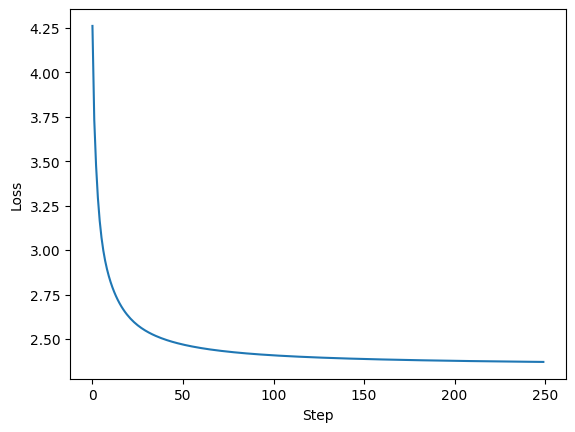

2.370595932006836


In [297]:
train(250, 25.0)